### Upload Data From BQ 2019 Data

In [ ]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT customer_id, address_id, time_interval, Fiscal_month, 
    sales_6M, coupon_expense_6M, Recency_6M, BUYS_Q_03,
    COUPON_Q_03, PH_PFREQ90D, PH_CFREQ90D, PH_REDEEM90D, PH_MREDEEM90D, 
    PH_MCPSALE90D, BBB_INSTORE_RFM_DECILE, BBB_ECOM_M_DECILE,
    NUM_PRODUCT_GROUPS, BBB_MOST_SHOP_STR_DIST, PRESENCE_OF_CHILD, 
    MARITAL_STAT, Target FROM `dw-bq-data-d00.QUANT_STG.TTS_90Days` 
    """
data = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data.head()

### Import Libraries

In [ ]:
from __future__ import division, print_function, absolute_import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sb
import seaborn as sns
from scipy.stats import skew, iqr
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, roc_auc_score, auc, confusion_matrix, roc_curve
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.metrics import confusion_matrix
pd.set_option('display.float_format', lambda x: '%.3f' % x)
%config Application.log_level = "ERROR"

### Imputation/ Data Type check

In [257]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5000000 entries, 0 to 4999999
Data columns (total 33 columns):
customer_id                 int64
address_id                  float64
time_interval               float64
PREVIOUS_BUY_DATE           object
Fiscal_month                object
sales_6M                    float64
coupon_expense_6M           float64
Frequency_6M                int64
Recency_6M                  float64
BUYS_Q_03                   object
COUPON_Q_03                 object
PH_PFREQ90D                 object
PH_CFREQ90D                 object
PH_REDEEM90D                object
PH_MREDEEM90D               object
PH_MCPSALE90D               object
PH_MREDEEM730D_PERC         object
BBB_INSTORE_RFM_DECILE      object
BBB_ECOM_R_DECILE           object
BBB_OFFCOUPON_RFM_DECILE    object
BBB_RFM_DECILE              object
BBB_RFM_DECILE_2Y           object
BBB_ECOM_M_DECILE           object
BBB_ONCOUPON_M_DECILE       object
pct_txns_on_mkd_disc        object
NUM_PERIO

In [ ]:

#Imputation
for col in data.columns:
    if 'DECILE' in col:
        data[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data[col].fillna(366, inplace=True)
    else:
        data[col].fillna(0, inplace=True)

data.isnull().sum()

key = ['customer_id','address_id'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data[key] = data[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','pct_txns_on_mkd_disc','HOME_STORE_DISTANCE_NBR','BBB_MOST_SHOP_STR_DIST']
data[key1]=data[key1].astype('int')
data.info()


### Capping the negatives

In [ ]:
data.sales_6M.loc[data.sales_6M<0]=0
data.coupon_expense_6M.loc[data.coupon_expense_6M<0]=0

### Correlation Check

<a id='eda'></a>

In [81]:
corr = data.corr()
print(abs(corr['Target'][:-1]).sort_values(ascending=False))
# sb.pairplot(data.sample(21987))
# plt.show()
#abs(corr['TARGET'][:-1]).sort_values(ascending=False).to_csv('Corr.csv')

Frequency_6M               0.424
NUM_PERIODS                0.328
BBB_INSTORE_RFM_DECILE     0.325
coupon_expense_6M          0.261
Recency_6M                 0.257
time_interval              0.254
sales_6M                   0.252
BBB_OFFCOUPON_RFM_DECILE   0.174
PH_MREDEEM90D              0.168
PH_PFREQ90D                0.159
PH_CFREQ90D                0.145
BBB_ECOM_R_DECILE          0.144
NUM_PRODUCT_GROUPS         0.074
pct_txns_on_mkd_disc       0.061
MARITAL_STAT               0.038
PRESENCE_OF_CHILD          0.033
EDU_1ST                    0.032
COUPON_Q_03                0.031
HOME_STORE_DISTANCE_NBR    0.028
BUYS_Q_03                  0.019
BBB_MOST_SHOP_STR_DIST     0.003
Name: Target, dtype: float64


<a id='sel'></a>

### Extra Tree Classifier (2019 Only)

In [9]:
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

In [11]:
from sklearn.metrics import classification_report, roc_auc_score, auc, confusion_matrix, roc_curve

In [ ]:
var_list2=['sales_6M',
 'Frequency_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']

In [16]:
#Parameter Grid

param_dist = {
    'n_estimators': list(range(100, 150, 20)),
    'max_depth': list(range(5, 20, 5)),
    'min_samples_split': list(range(2, 21, 4)),
    'min_samples_leaf': list(range(2, 11, 2)),
    'max_features': [0.5, 0.1, 'auto'],
    'min_impurity_decrease': [0.1, 0.00001]
}

y = data[target]

d2_train, d2_test, y2_train, y2_test = train_test_split(data[var_list2],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [31]:

tree3 = ExtraTreesClassifier(criterion="entropy",
                            class_weight="balanced",
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)
    
tree_search3 = RandomizedSearchCV(tree3,
                                 param_distributions=param_dist,
                                 cv=3,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='neg_log_loss',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search3.fit(d2_train, y2_train)

print(
    'Report on Training:\n',
    classification_report(y2_train,
                          tree_search3.best_estimator_.predict(d2_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(y2_test, tree_search3.best_estimator_.predict(d2_test)))



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Report on Training:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72   1765173
           1       0.78      0.75      0.76   2234827

    accuracy                           0.74   4000000
   macro avg       0.74      0.74      0.74   4000000
weighted avg       0.75      0.74      0.74   4000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.70      0.74      0.72    442500
           1       0.78      0.75      0.76    557500

    accuracy                           0.74   1000000
   macro avg       0.74      0.74      0.74   1000000
weighted avg       0.75      0.74      0.74   1000000



In [406]:
print(tree_search3.best_estimator_)

ExtraTreesClassifier(bootstrap=True, class_weight='balanced',
                     criterion='entropy', max_depth=15, max_features=0.5,
                     max_leaf_nodes=None, min_impurity_decrease=1e-05,
                     min_impurity_split=None, min_samples_leaf=10,
                     min_samples_split=14, min_weight_fraction_leaf=0.0,
                     n_estimators=100, n_jobs=None, oob_score=True,
                     random_state=42, verbose=0, warm_start=False)


### ROC Curve and Feature Importance

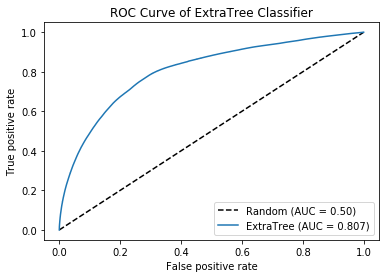

Frequency_6M : 0.5286
BBB_INSTORE_RFM_DECILE : 0.2369
NUM_PERIODS : 0.1228
PH_PFREQ90D : 0.0218
BBB_OFFCOUPON_RFM_DECILE : 0.0176
PH_CFREQ90D : 0.0149
sales_6M : 0.0129
NUM_PRODUCT_GROUPS : 0.0129
BBB_ECOM_R_DECILE : 0.011
MARITAL_STAT : 0.0069
PRESENCE_OF_CHILD : 0.004
PH_MREDEEM90D : 0.0039
COUPON_Q_03 : 0.0039
BUYS_Q_03 : 0.0019


In [67]:
fpr_, tpr_, thresholds_ = roc_curve(
    y2_test,
    tree_search3.best_estimator_.predict_proba(d2_test)[:, 1])

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.plot(fpr_, tpr_, label='ExtraTree (AUC = %0.3f)' % (auc(fpr_, tpr_)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve of ExtraTree Classifier')
plt.legend(loc='best')
plt.show()

for imp, feature in sorted(zip(
        tree_search3.best_estimator_.feature_importances_, d2_test.columns),
                           reverse=True):
    print(feature, ':', round(imp, 4))

### Import 2021 Data (March-Aug)+2019 Data

In [126]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_90Days_Final_Train`
    """
data6 = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data6.head()

,CUSTOMER_ID,TIME_INTERVAL,PREVIOUS_BUY_DATE,FISCAL_MONTH,SALES_6M,FREQUENCY_6M,BUYS_Q_03,COUPON_Q_03,PH_MREDEEM90D,PH_PFREQ90D,PH_CFREQ90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,MARITAL_STAT,TARGET
0,1000189553463,40.000,05MAY2021,2021P03,420.960,2,1.000,1.000,0.000,2.000,2.000,5.000,7.000,10.000,3.000,2.000,99,1,1
1,1001092875275,66.000,28MAY2021,2021P03,134.680,6,1.000,1.000,0.000,0.000,0.000,1.000,2.000,1.000,11.000,2.000,2,2,1
2,1000343775485,nan,06MAY2021,2021P03,59.970,1,1.000,1.000,0.000,2.000,2.000,2.000,nan,nan,2.000,2.000,1,2,0
3,1000064301326,6.000,08MAY2021,2021P03,2.490,1,1.000,1.000,0.000,0.000,2.000,2.000,nan,3.000,3.000,1.000,1,1,1
4,1000020584146,92.000,18MAY2021,2021P03,55.930,1,1.000,1.000,1.000,2.000,2.000,2.000,nan,7.000,3.000,1.000,1,1,0


In [128]:
#Imputation
for col in data6.columns:
    if 'DECILE' in col:
        data6[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data6[col].fillna(366, inplace=True)
    else:
        data6[col].fillna(0, inplace=True)

data6.isnull().sum()

CUSTOMER_ID                 0
TIME_INTERVAL               0
PREVIOUS_BUY_DATE           0
FISCAL_MONTH                0
SALES_6M                    0
FREQUENCY_6M                0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_MREDEEM90D               0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PRESENCE_OF_CHILD           0
MARITAL_STAT                0
TARGET                      0
dtype: int64

In [130]:
data6.SALES_6M.loc[data6.SALES_6M<0]=0

In [132]:
key = ['CUSTOMER_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data6[key] = data6[key].astype("object")
data6['PREVIOUS_BUY_DATE'] = pd.to_datetime(data6['PREVIOUS_BUY_DATE'])
data6.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000000 entries, 0 to 9999999
Data columns (total 19 columns):
CUSTOMER_ID                 object
TIME_INTERVAL               float64
PREVIOUS_BUY_DATE           datetime64[ns]
FISCAL_MONTH                object
SALES_6M                    float64
FREQUENCY_6M                int64
BUYS_Q_03                   float64
COUPON_Q_03                 float64
PH_MREDEEM90D               float64
PH_PFREQ90D                 float64
PH_CFREQ90D                 float64
BBB_INSTORE_RFM_DECILE      float64
BBB_ECOM_R_DECILE           float64
BBB_OFFCOUPON_RFM_DECILE    float64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
MARITAL_STAT                int64
TARGET                      int64
dtypes: datetime64[ns](1), float64(12), int64(4), object(2)
memory usage: 1.4+ GB


In [151]:
var_list=['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']

In [152]:
param_dist = {
    'n_estimators': list(range(100, 150, 20)),
    'max_depth': list(range(5, 20, 5)),
    'min_samples_split': list(range(2, 21, 4)),
    'min_samples_leaf': list(range(2, 11, 2)),
    'max_features': [0.5, 0.1, 'auto'],
    'min_impurity_decrease': [0.1, 0.00001]
    
}

y = data6[['TARGET']]

dd_train, dd_test, yy_train, yy_test = train_test_split(data6[var_list],
                                                    y,
                                                    test_size=0.2,
                                                    random_state=42)

In [156]:
tree = ExtraTreesClassifier(criterion="entropy",
                            class_weight="balanced",
                            bootstrap=True,
                            oob_score=True,
                            random_state=42)

tree_search_n = RandomizedSearchCV(tree,
                                 param_distributions=param_dist,
                                 cv=3,
                                 n_iter=10,
                                 random_state=42,
                                 scoring='neg_log_loss',
                                 refit=True,
                                 n_jobs=16,
                                 verbose=1)


tree_search_n.fit(dd_train, yy_train.values.ravel())

print(
    'Report on Training:\n',
    classification_report(yy_train,
                          tree_search_n.best_estimator_.predict(dd_train)))
print('---------------------------------------------------\n')
print(
    'Report on Testing:\n',
    classification_report(yy_test, tree_search_n.best_estimator_.predict(dd_test)))



Fitting 3 folds for each of 10 candidates, totalling 30 fits
Report on Training:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75   3950502
           1       0.76      0.74      0.75   4049498

    accuracy                           0.75   8000000
   macro avg       0.75      0.75      0.75   8000000
weighted avg       0.75      0.75      0.75   8000000

---------------------------------------------------

Report on Testing:
               precision    recall  f1-score   support

           0       0.74      0.77      0.75    988404
           1       0.76      0.74      0.75   1011596

    accuracy                           0.75   2000000
   macro avg       0.75      0.75      0.75   2000000
weighted avg       0.75      0.75      0.75   2000000



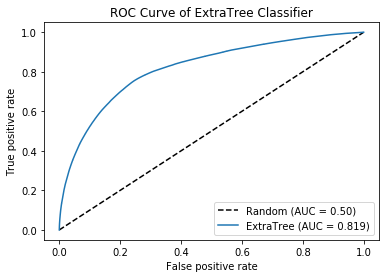

FREQUENCY_6M : 0.5619
NUM_PERIODS : 0.2049
BBB_INSTORE_RFM_DECILE : 0.1329
PH_PFREQ90D : 0.0246
BBB_ECOM_R_DECILE : 0.0177
PH_CFREQ90D : 0.0153
SALES_6M : 0.0098
PH_MREDEEM90D : 0.0089
BBB_OFFCOUPON_RFM_DECILE : 0.0077
MARITAL_STAT : 0.0067
PRESENCE_OF_CHILD : 0.0029
NUM_PRODUCT_GROUPS : 0.0025
COUPON_Q_03 : 0.0025
BUYS_Q_03 : 0.0015


In [233]:
fpr_, tpr_, thresholds_ = roc_curve(
    yy_test,
    tree_search_n.best_estimator_.predict_proba(dd_test)[:, 1])

plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--', label='Random (AUC = 0.50)')
plt.plot(fpr_, tpr_, label='ExtraTree (AUC = %0.3f)' % (auc(fpr_, tpr_)))

plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC Curve of ExtraTree Classifier')
plt.legend(loc='best')
plt.show()

for imp, feature in sorted(zip(
        tree_search_n.best_estimator_.feature_importances_, dd_test.columns),
                           reverse=True):
    print(feature, ':', round(imp, 4))

[[756402 232002]
 [260812 750784]]


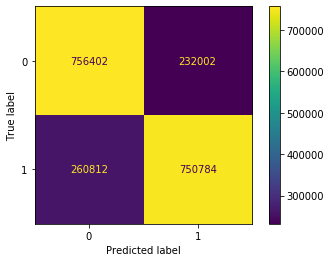

In [260]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(tree_search_n.best_estimator_,
                             dd_test,
                             yy_test,
                             normalize=None)

print(disp.confusion_matrix)

In [261]:
import pickle

In [262]:
filename = 'finalized_model.sav'
pickle.dump(tree_search_n.best_estimator_, open(filename, 'wb'))

In [265]:
loaded_model = pickle.load(open(filename, 'rb'))
result = loaded_model.score(dd_train, yy_train)
print(result)

0.75367025


In [297]:
np.percentile(prob11, np.arange(0, 100, 10))

array([0.1115064 , 0.19662877, 0.21054794, 0.25123934, 0.26712146,
       0.42682036, 0.493293  , 0.59348687, 0.67486295, 0.77079006])

In [299]:
probn1=tree_search_n.predict_proba(dd_train)
prob11=probn1[:,1]
prob01=probn1[:,0]
predicted1 = tree_search_n.predict(dd_train)


In [300]:
probability = pd.DataFrame({'p':prob11})

In [302]:
bin_labels_10 = ['10', '9', '8', '7', '6','5','4','3','2','1']
probability['decile'] = pd.qcut(probability['p'],
                              q=10,
                              labels=bin_labels_10)

### Out of Time Validation (March 2021-June 2021)

In [157]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_JUNE2021_TEST`
    """
data3 = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data3.head()

,CUSTOMER_ID,TIME_LAST_PURCHASE,TARGET,TIMELINE,FIRST_TRANS,SALES_6M,COUPON_EXPENSE_6M,FREQUENCY_6M,RECENCY_6M,NUM_PERIODS,...,EDU_1ST,MARITAL_STAT,PH_PFREQ90D,PH_CFREQ90D,PH_MREDEEM90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,BUYS_Q_03,COUPON_Q_03
0,1000088235541,15.000,1,April 2021,17MAR2021,819.600,173.070,10,22.000,12.000,...,1.000,1.000,0.000,2.000,0.000,1.000,2.000,3.000,5.000,5.000
1,1000218183201,21.000,1,April 2021,21MAR2021,352.590,64.660,11,13.000,12.000,...,1.000,1.000,1.000,2.000,1.000,1.000,10.000,1.000,7.000,6.000
2,1000001034796,11.000,1,April 2021,23MAR2021,310.540,57.440,9,50.000,12.000,...,1.000,2.000,2.000,0.000,0.000,1.000,nan,4.000,7.000,6.000
3,1000196875885,27.000,1,April 2021,31MAR2021,1175.690,218.540,14,20.000,12.000,...,99.000,99.000,0.000,0.000,0.000,1.000,8.000,2.000,6.000,5.000
4,1000226743351,19.000,1,April 2021,23MAR2021,1448.860,297.730,19,3.000,12.000,...,1.000,1.000,0.000,2.000,0.000,1.000,10.000,10.000,9.000,9.000


In [158]:
data3.SALES_6M.loc[data3.SALES_6M<0]=0
data3.COUPON_EXPENSE_6M.loc[data3.COUPON_EXPENSE_6M<0]=0

/opt/conda/envs/tts/lib/python3.7/site-packages/pandas/core/indexing.py:205: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_with_indexer(indexer, value)


In [159]:
#Imputation
for col in data3.columns:
    if 'DECILE' in col:
        data3[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data3[col].fillna(366, inplace=True)
    else:
        data3[col].fillna(0, inplace=True)

data3.isnull().sum()

CUSTOMER_ID                 0
TIME_LAST_PURCHASE          0
TARGET                      0
TIMELINE                    0
FIRST_TRANS                 0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
RECENCY_6M                  0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PCT_TXNS_ON_MKD_DISC        0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
PH_MREDEEM90D               0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
BUYS_Q_03                   0
COUPON_Q_03                 0
dtype: int64

In [160]:
key = ['CUSTOMER_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data3[key] = data3[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC']
data3[key1]=data3[key1].astype('int')
data3.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4528811 entries, 0 to 4528810
Data columns (total 23 columns):
CUSTOMER_ID                 object
TIME_LAST_PURCHASE          float64
TARGET                      int64
TIMELINE                    object
FIRST_TRANS                 object
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
RECENCY_6M                  float64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PCT_TXNS_ON_MKD_DISC        int64
PRESENCE_OF_CHILD           float64
EDU_1ST                     float64
MARITAL_STAT                float64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
PH_MREDEEM90D               int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
dtypes: float64(9), int64(11), object(3)
memory usage: 794.7+ MB


In [166]:
var_list3=['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']

In [164]:
target_J=data3['TARGET']

In [167]:
#Without Recency ET 
print(
    'Report on Testing Out of Time Data (March-June 2021):\n',
    classification_report(target_J,
                          tree_search_n.best_estimator_.predict(data3[var_list3])))

Report on Testing Out of Time Data (March-June 2021):
               precision    recall  f1-score   support

           0       0.71      0.84      0.77   2995593
           1       0.52      0.33      0.40   1533218

    accuracy                           0.67   4528811
   macro avg       0.61      0.59      0.59   4528811
weighted avg       0.65      0.67      0.65   4528811



[[2527093  468500]
 [1030175  503043]]


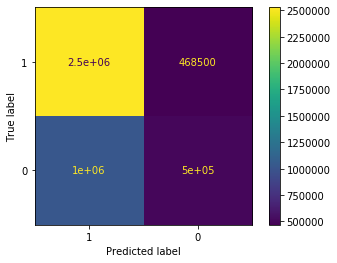

In [258]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(tree_search_n.best_estimator_,
                             data3[var_list3],
                             target_J,
                             display_labels=target_J.unique(),
                             normalize=None)

print(disp.confusion_matrix)

## Out of Time Production (July 2021 - Sep 2021) No Target --- Used for Market Basket

In [190]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.QUANT_STG.TTS_PROD_SEP2021`
    """
data_test = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data_test.head(20)

,CUSTOMER_ID,ADDRESS_ID,TRANS_BOOKED_DT,TRANS_ID,PERSONA,NEAR_RANK,FISCAL_MONTH,P_ALIVE,PRED_FREQ_1YR,ONE_YEAR_VALUE,...,PH_PFREQ90D,PH_CFREQ90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT
0,1000233121765,3000131000731,20SEP2021,4160151418,NESTER,4,2021P07,0.991,3,72.210,...,5.000,2.000,1.000,3.000,nan,5.000,1.000,1,1,1
1,1000280470642,3000089942483,20SEP2021,4160137585,THOUGHTFUL APPRECIATOR,4,2021P07,0.990,3,59.930,...,5.000,1.000,3.000,2.000,1.000,5.000,1.000,1,1,1
2,1000046629764,3000040962172,20SEP2021,4160376559,JUGGLER,4,2021P07,0.979,1,20.160,...,5.000,2.000,1.000,nan,6.000,5.000,3.000,1,2,1
3,1000112156718,3000121991239,20SEP2021,4160359146,None,4,2021P07,0.961,4,98.100,...,0.000,0.000,5.000,1.000,1.000,5.000,2.000,99,99,99
4,1000151859221,3000102572351,20SEP2021,4160389661,NESTER,4,2021P07,0.997,5,52.260,...,5.000,2.000,1.000,nan,1.000,5.000,3.000,99,1,2
5,1000063529532,3000216218703,20SEP2021,4160756012,JUGGLER,4,2021P07,0.927,3,68.270,...,0.000,1.000,nan,1.000,4.000,5.000,1.000,99,99,2
6,1000209708169,3000002944726,20SEP2021,4160341971,CREATIVE,4,2021P07,0.990,3,77.660,...,1.000,2.000,nan,1.000,1.000,5.000,1.000,99,1,99
7,1000105389283,3000346790948,20SEP2021,4160376210,JUGGLER,4,2021P07,0.959,6,59.240,...,5.000,2.000,1.000,9.000,nan,5.000,4.000,99,99,2
8,1000310210076,3000013015180,20SEP2021,4160207150,NESTER,4,2021P07,0.997,9,131.460,...,5.000,1.000,1.000,nan,3.000,5.000,1.000,1,1,1
9,1000261886208,3000022005775,20SEP2021,4160122617,NESTER,4,2021P07,0.963,16,434.210,...,1.000,0.000,4.000,1.000,1.000,5.000,4.000,1,1,1


In [191]:
#Imputation
for col in data_test.columns:
    if 'DECILE' in col:
        data_test[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data_test[col].fillna(366, inplace=True)
    elif 'Recency_6M' in col:
        data_test[col].fillna(366, inplace=True)
    else:
        data_test[col].fillna(0, inplace=True)

data_test.isnull().sum()

CUSTOMER_ID                 0
ADDRESS_ID                  0
TRANS_BOOKED_DT             0
TRANS_ID                    0
PERSONA                     0
NEAR_RANK                   0
FISCAL_MONTH                0
P_ALIVE                     0
PRED_FREQ_1YR               0
ONE_YEAR_VALUE              0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
PCT_TXNS_ON_MKD_DISC        0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_MREDEEM90D               0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
dtype: int64

In [192]:
data_test.SALES_6M.loc[data_test.SALES_6M<0]=0
data_test.COUPON_EXPENSE_6M.loc[data_test.COUPON_EXPENSE_6M<0]=0
key = ['CUSTOMER_ID','ADDRESS_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data_test[key] = data_test[key].astype("object")
key1 = ['BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC']
data_test[key1]=data_test[key1].astype('int')
data_test.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10157003 entries, 0 to 10157002
Data columns (total 27 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
TRANS_BOOKED_DT             object
TRANS_ID                    int64
PERSONA                     object
NEAR_RANK                   int64
FISCAL_MONTH                object
P_ALIVE                     float64
PRED_FREQ_1YR               int64
ONE_YEAR_VALUE              float64
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
PCT_TXNS_ON_MKD_DISC        int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
EDU_1ST           

In [193]:
Score=data_test[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [195]:
predicted = tree_search_n.predict(Score)
predicted_df = pd.DataFrame(data=predicted, columns=['y_hat'], 
                            index=data_test.index.copy())
Proba = pd.DataFrame(data=prob1, columns=['P'], 
                            index=data_test.index.copy())


In [196]:
probn=tree_search_n.predict_proba(Score)
prob1=probn[:,1]
prob0=probn[:,0]


In [197]:
df_out = pd.merge(data_test, predicted_df, how ='left', left_index=True, 
                 right_index=True)

In [198]:
df_out1 = pd.merge(df_out, Proba, how ='left', left_index=True, 
                 right_index=True)

In [199]:
df_out1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10157003 entries, 0 to 10157002
Data columns (total 29 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
TRANS_BOOKED_DT             object
TRANS_ID                    int64
PERSONA                     object
NEAR_RANK                   int64
FISCAL_MONTH                object
P_ALIVE                     float64
PRED_FREQ_1YR               int64
ONE_YEAR_VALUE              float64
SALES_6M                    float64
COUPON_EXPENSE_6M           float64
FREQUENCY_6M                int64
PCT_TXNS_ON_MKD_DISC        int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
EDU_1ST           

### OAD Validation (2019 Nov - 2020 Oct) 

In [174]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.SANDBOX_ANALYTICS.TS_OAD_SCORE_TTS`
    """
data_oad = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data_oad.head(20)

,CUSTOMER_ID,ADDRESS_ID,ACTIVE_P,ACTIVE_SEG,MIN_DATE,MAX_DATE,PERIOD,OAD,SALES_6M,COUPON_EXPENSE_6M,...,PH_CFREQ90D,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,pct_txns_on_mkd_disc,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT
0,1000182621489,3000114853657,1,N,2019-11-25,2020-09-01,201911,0,89.990000000,0E-9,...,0,None,None,None,0E-9,1.000,1.000,1,1,1
1,1000336337473,3000047805316,1,N,2020-05-24,2020-12-28,20205,0,31.980000000,4.000000000,...,0,None,None,None,0E-9,1.000,2.000,1,1,1
2,1000867197929,3000069202047,1,N,2020-07-06,2020-07-06,20207,1,82.970000000,6.600000000,...,0,None,None,None,0E-9,1.000,1.000,1,1,1
3,1000154344952,3000032053781,1,N,2019-11-10,2019-11-10,201911,1,106.660000000,10.000000000,...,0,None,None,None,0E-9,1.000,1.000,1,1,2
4,1000284393508,3000080574317,1,N,2020-04-21,2020-04-21,20204,1,14.990000000,0E-9,...,0,None,None,None,0E-9,1.000,1.000,99,99,99
5,1000932763325,3000042832593,1,N,2020-09-23,2020-09-27,20209,1,141.990000000,28.400000000,...,0,None,10.000000000,None,0E-9,1.000,1.000,1,1,1
6,1000143144938,3000098701732,2,N,2020-03-10,2020-05-11,20203,0,247.980000000,0E-9,...,0,None,None,None,0.500000000,1.000,9.000,2,1,1
7,1000258356369,3000065932022,1,R,2019-11-26,2019-11-26,201911,1,167.870000000,41.600000000,...,2,None,None,None,0E-9,1.000,1.000,1,1,2
8,1000270317817,3000058727265,3,R,2020-07-23,2020-07-23,20207,1,42.990000000,8.600000000,...,0,None,None,None,0E-9,1.000,1.000,99,99,99
9,1000081374131,3000065312247,2,R,2020-02-09,2020-09-27,20202,0,61.980000000,12.000000000,...,0,None,None,None,0E-9,1.000,2.000,1,99,1


In [178]:
#Imputation
for col in data_oad.columns:
    if 'DECILE' in col:
        data_oad[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data_oad[col].fillna(366, inplace=True)
    else:
        data_oad[col].fillna(0, inplace=True)

data_oad.isnull().sum()

CUSTOMER_ID                 0
ADDRESS_ID                  0
ACTIVE_P                    0
ACTIVE_SEG                  0
MIN_DATE                    0
MAX_DATE                    0
PERIOD                      0
OAD                         0
SALES_6M                    0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_MREDEEM90D               0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
pct_txns_on_mkd_disc        0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
dtype: int64

In [179]:
data_oad.SALES_6M.loc[data_oad.SALES_6M<0]=0
data_oad.COUPON_EXPENSE_6M.loc[data_oad.COUPON_EXPENSE_6M<0]=0
key = ['CUSTOMER_ID','ADDRESS_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data_oad[key] = data_oad[key].astype("object")
key1 = ['SALES_6M','COUPON_EXPENSE_6M','BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','pct_txns_on_mkd_disc']
data_oad[key1]=data_oad[key1].astype('int')
data_oad.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18450430 entries, 0 to 18450429
Data columns (total 25 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
ACTIVE_P                    int64
ACTIVE_SEG                  object
MIN_DATE                    object
MAX_DATE                    object
PERIOD                      object
OAD                         int64
SALES_6M                    int64
COUPON_EXPENSE_6M           int64
FREQUENCY_6M                int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
pct_txns_on_mkd_disc        int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
EDU_1ST                     int64
MARITAL_STAT                int64
dtypes: float64(2), int64

In [180]:
Score1=data_oad[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [202]:
probn=tree_search_n.predict_proba(Score1)
prob1=probn[:,1]
prob0=probn[:,0]


In [203]:
predicted = tree_search_n.predict(Score1)
predicted_df = pd.DataFrame(data=predicted, columns=['Prediction'], 
                            index=data_oad.index.copy())
Proba = pd.DataFrame(data=prob1, columns=['Prob'], 
                            index=data_oad.index.copy())


In [213]:
df_out = pd.merge(data_oad, predicted_df, how ='left', left_index=True, 
                 right_index=True)

In [214]:
df_out1 = pd.merge(df_out, Proba, how ='left', left_index=True, 
                 right_index=True)

In [231]:
Dict = {'True OAD Population': df_out1[df_out1["OAD"]==1].count()["CUSTOMER_ID"],
        'OAD Predicted/ Non Shoppers':df_out1[(df_out1["OAD"]==1) & (df_out1["Prediction"]==0)].count()["CUSTOMER_ID"]
        /data_oad[data_oad["OAD"]==1].count()["CUSTOMER_ID"]*100,'Total Shoppers Predicted (1)':df_out1[df_out1["Prediction"]==1].count()["CUSTOMER_ID"]}

In [232]:
Dict

{'True OAD Population': 11533382,
 'OAD Predicted/ Non Shoppers': 99.88639932328608,
 'Total Shoppers Predicted (1)': 23571}

In [234]:
print(
    'Report on OAD Testing:\n',
    classification_report(data_oad['OAD'], tree_search_n.predict(Score1)))


Report on OAD Testing:
               precision    recall  f1-score   support

           0       0.37      1.00      0.55   6917048
           1       0.56      0.00      0.00  11533382

    accuracy                           0.38  18450430
   macro avg       0.47      0.50      0.27  18450430
weighted avg       0.49      0.38      0.21  18450430



In [249]:
cf_matrix = confusion_matrix(data_oad['OAD'], tree_search_n.predict(Score1))

In [250]:
cf_matrix

array([[ 6906579,    10469],
       [11520280,    13102]])

[[ 6906579    10469]
 [11520280    13102]]


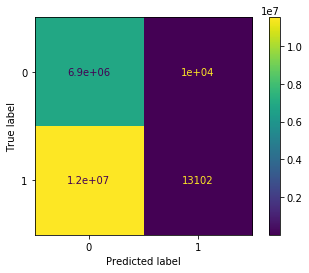

In [257]:
from sklearn.metrics import plot_confusion_matrix
disp = plot_confusion_matrix(tree_search_n.best_estimator_,
                             Score1,
                             data_oad['OAD'],
                             display_labels=data_oad['OAD'].unique(),
                             normalize=None)

print(disp.confusion_matrix)

In [270]:
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas

key_path = '/home/jupyter/d00_key.json'
credentials = service_account.Credentials.from_service_account_file(
    key_path, scopes=["https://www.googleapis.com/auth/cloud-platform"],
)

bq_client = bigquery.Client(credentials=credentials, project=credentials.project_id)
bqstorageclient = bigquery_storage.BigQueryReadClient(credentials=credentials)

QUERY = """
    SELECT *
    FROM `dw-bq-data-d00.SANDBOX_ANALYTICS.tts_dec2021_test`
    """
data_oad = bq_client.query(QUERY).result().to_dataframe(bqstorage_client=bqstorageclient)
data_oad.head()

,CUSTOMER_ID,ADDRESS_ID,PREVIOUS_PURCHASE,SALES_6M,FISCAL_MONTH,COUPON_EXPENSE_6M,FREQUENCY_6M,PCT_TXNS_ON_MKD_DISC,BUYS_Q_03,COUPON_Q_03,...,promohistory_pfrequency_90_days,promohistory_circle_frequency_90_days,beyond_INSTORE_recency_frequency_monetary_DECILE,beyond_ECOM_recency_DECILE,beyond_OFFCOUPON_recency_frequency_monetary_DECILE,NUM_PERIODS,number_product_groups,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT
0,1000292453071,3000053560141.000,2021-10-14,125.410000000,2021P07,0E-9,3,nan,0.000,0.000,...,nan,nan,3.000000000,None,1.000000000,nan,nan,1,3,1
1,1000188375210,3000056661961.000,2021-10-14,19.990000000,2021P07,4.000000000,1,nan,0.000,0.000,...,nan,nan,1.000000000,1.000000000,1.000000000,nan,nan,2,99,2
2,1000106788822,3000072863599.000,2021-10-14,24.990000000,2021P07,5.000000000,2,nan,0.000,0.000,...,nan,nan,9.000000000,None,None,nan,nan,2,99,1
3,1000276912915,3000110384718.000,2021-10-14,9.990000000,2021P07,2.000000000,1,nan,0.000,0.000,...,nan,nan,None,10.000000000,None,nan,nan,2,2,1
4,1000135910819,3000095347550.000,2021-10-14,235.340000000,2021P07,35.800000000,2,nan,0.000,0.000,...,nan,nan,2.000000000,None,7.000000000,nan,nan,1,3,2


In [281]:
Score1=data_oad[['SALES_6M',
 'FREQUENCY_6M',
 'BUYS_Q_03',
 'COUPON_Q_03',
 'PH_MREDEEM90D',
 'PH_PFREQ90D',
 'PH_CFREQ90D',
 'BBB_INSTORE_RFM_DECILE',
 'BBB_ECOM_R_DECILE',
 'BBB_OFFCOUPON_RFM_DECILE',
 'NUM_PERIODS',
 'NUM_PRODUCT_GROUPS',
 'PRESENCE_OF_CHILD',
 'MARITAL_STAT']]

In [277]:
data_oad=data_oad.rename(columns={"promohistory_main_event_redeem_90_days": "PH_MREDEEM90D", "promohistory_pfrequency_90_days": "PH_PFREQ90D","promohistory_circle_frequency_90_days": "PH_CFREQ90D","beyond_INSTORE_recency_frequency_monetary_DECILE": "BBB_INSTORE_RFM_DECILE","beyond_ECOM_recency_DECILE": "BBB_ECOM_R_DECILE","beyond_OFFCOUPON_recency_frequency_monetary_DECILE": "BBB_OFFCOUPON_RFM_DECILE","number_product_groups": "NUM_PRODUCT_GROUPS"})

In [280]:
#Imputation
for col in data_oad.columns:
    if 'DECILE' in col:
        data_oad[col].fillna(11, inplace=True)
    elif '_R' in col and 'DECILE' not in col:
        data_oad[col].fillna(366, inplace=True)
    else:
        data_oad[col].fillna(0, inplace=True)

data_oad.isnull().sum()

CUSTOMER_ID                 0
ADDRESS_ID                  0
PREVIOUS_PURCHASE           0
SALES_6M                    0
FISCAL_MONTH                0
COUPON_EXPENSE_6M           0
FREQUENCY_6M                0
PCT_TXNS_ON_MKD_DISC        0
BUYS_Q_03                   0
COUPON_Q_03                 0
PH_MREDEEM90D               0
PH_PFREQ90D                 0
PH_CFREQ90D                 0
BBB_INSTORE_RFM_DECILE      0
BBB_ECOM_R_DECILE           0
BBB_OFFCOUPON_RFM_DECILE    0
NUM_PERIODS                 0
NUM_PRODUCT_GROUPS          0
PRESENCE_OF_CHILD           0
EDU_1ST                     0
MARITAL_STAT                0
dtype: int64

In [278]:
data_oad.SALES_6M.loc[data_oad.SALES_6M<0]=0
data_oad.COUPON_EXPENSE_6M.loc[data_oad.COUPON_EXPENSE_6M<0]=0
key = ['CUSTOMER_ID','ADDRESS_ID'] # if you have keys like address_id, customer_id, you should change to object from int etc.
data_oad[key] = data_oad[key].astype("object")
key1 = ['SALES_6M','COUPON_EXPENSE_6M','BUYS_Q_03','COUPON_Q_03','PH_MREDEEM90D','PH_PFREQ90D','PH_CFREQ90D','BBB_INSTORE_RFM_DECILE','BBB_ECOM_R_DECILE','BBB_OFFCOUPON_RFM_DECILE','PCT_TXNS_ON_MKD_DISC']
data_oad[key1]=data_oad[key1].astype('int')
data_oad.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15172471 entries, 0 to 15172470
Data columns (total 21 columns):
CUSTOMER_ID                 object
ADDRESS_ID                  object
PREVIOUS_PURCHASE           object
SALES_6M                    int64
FISCAL_MONTH                object
COUPON_EXPENSE_6M           int64
FREQUENCY_6M                int64
PCT_TXNS_ON_MKD_DISC        int64
BUYS_Q_03                   int64
COUPON_Q_03                 int64
PH_MREDEEM90D               int64
PH_PFREQ90D                 int64
PH_CFREQ90D                 int64
BBB_INSTORE_RFM_DECILE      int64
BBB_ECOM_R_DECILE           int64
BBB_OFFCOUPON_RFM_DECILE    int64
NUM_PERIODS                 float64
NUM_PRODUCT_GROUPS          float64
PRESENCE_OF_CHILD           int64
EDU_1ST                     int64
MARITAL_STAT                int64
dtypes: float64(2), int64(15), object(4)
memory usage: 2.4+ GB


In [ ]:
data_oad.info()

In [282]:
probn=tree_search_n.predict_proba(Score1)
prob1=probn[:,1]
prob0=probn[:,0]
predicted = tree_search_n.predict(Score1)
predicted_df = pd.DataFrame(data=predicted, columns=['Prediction'], 
                            index=data_oad.index.copy())
Proba = pd.DataFrame(data=prob1, columns=['Prob'], 
                            index=data_oad.index.copy())


In [284]:
df_out = pd.merge(data_oad[['CUSTOMER_ID','ADDRESS_ID']] , predicted_df, how ='left', left_index=True, 
                 right_index=True)

In [285]:
df_out1 = pd.merge(df_out, Proba, how ='left', left_index=True, 
                 right_index=True)

In [324]:
cut_labels_10 = ['10', '9', '8', '7', '6','5','4','3','2','1']
cut_bins = [0.00, 0.19662877, 0.21054794, 0.25123934, 0.26712146,
       0.42682036, 0.493293  , 0.59348687, 0.67486295, 0.77079006,1]
df_out1['decile'] = pd.cut(df_out1['Prob'], bins=cut_bins, labels=cut_labels_10)

In [322]:
df_out1.max()

CUSTOMER_ID                    1001295420600
ADDRESS_ID                 3000413898104.000
PREVIOUS_PURCHASE                 2021-11-28
SALES_6M                              413359
FISCAL_MONTH                         2021P08
COUPON_EXPENSE_6M                      82067
FREQUENCY_6M                              20
PCT_TXNS_ON_MKD_DISC                       1
BUYS_Q_03                                180
COUPON_Q_03                              140
PH_MREDEEM90D                             10
PH_PFREQ90D                               18
PH_CFREQ90D                               16
BBB_INSTORE_RFM_DECILE                    11
BBB_ECOM_R_DECILE                         11
BBB_OFFCOUPON_RFM_DECILE                  11
NUM_PERIODS                           12.000
NUM_PRODUCT_GROUPS                    23.000
PRESENCE_OF_CHILD                         99
EDU_1ST                                   99
MARITAL_STAT                              99
Prediction                                 1
Prob      

In [293]:
Dict = {'Total Shoppers Predicted (0)':df_out1[df_out1["Prediction"]==0].count()["CUSTOMER_ID"],
        'Total Shoppers Predicted (1)':df_out1[df_out1["Prediction"]==1].count()["CUSTOMER_ID"],
        '% Shoppers Predicted (1)':round((df_out1[df_out1["Prediction"]==1].count()["CUSTOMER_ID"]/df_out1.count()["CUSTOMER_ID"])*100,2),
        '% Shoppers Predicted (0)':round((df_out1[df_out1["Prediction"]==0].count()["CUSTOMER_ID"]/df_out1.count()["CUSTOMER_ID"])*100,2)}

In [294]:
Dict

{'Total Shoppers Predicted (0)': 9250675,
 'Total Shoppers Predicted (1)': 5921796,
 '% Shoppers Predicted (1)': 39.03,
 '% Shoppers Predicted (0)': 60.97}

In [295]:
df_out1

,CUSTOMER_ID,ADDRESS_ID,PREVIOUS_PURCHASE,SALES_6M,FISCAL_MONTH,COUPON_EXPENSE_6M,FREQUENCY_6M,PCT_TXNS_ON_MKD_DISC,BUYS_Q_03,COUPON_Q_03,...,BBB_INSTORE_RFM_DECILE,BBB_ECOM_R_DECILE,BBB_OFFCOUPON_RFM_DECILE,NUM_PERIODS,NUM_PRODUCT_GROUPS,PRESENCE_OF_CHILD,EDU_1ST,MARITAL_STAT,Prediction,Prob
0,1000292453071,3000053560141.000,2021-10-14,125,2021P07,0,3,0,0,0,...,3,11,1,0.000,0.000,1,3,1,1,0.578
1,1000188375210,3000056661961.000,2021-10-14,19,2021P07,4,1,0,0,0,...,1,1,1,0.000,0.000,2,99,2,1,0.594
2,1000106788822,3000072863599.000,2021-10-14,24,2021P07,5,2,0,0,0,...,9,11,11,0.000,0.000,2,99,1,0,0.453
3,1000276912915,3000110384718.000,2021-10-14,9,2021P07,2,1,0,0,0,...,11,10,11,0.000,0.000,2,2,1,0,0.202
4,1000135910819,3000095347550.000,2021-10-14,235,2021P07,35,2,0,0,0,...,2,11,7,0.000,0.000,1,3,2,1,0.617
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15172466,1000109293101,3000141079798.000,2021-10-04,68,2021P07,14,5,0,0,0,...,4,11,11,0.000,0.000,2,99,1,1,0.707
15172467,1000127881027,3000008887032.000,2021-10-04,89,2021P07,0,1,0,0,0,...,9,11,11,0.000,0.000,1,1,2,0,0.216
15172468,1000120033052,3000084775741.000,2021-10-04,61,2021P07,0,1,0,0,0,...,11,11,11,0.000,0.000,99,99,99,0,0.267
15172469,1000023679940,3000022133736.000,2021-10-04,105,2021P07,31,1,0,0,0,...,10,11,11,0.000,0.000,2,1,1,0,0.215


In [5]:
# importing necessary libraries
from google.oauth2 import service_account
from google.cloud import bigquery
from google.cloud import bigquery_storage
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import pickle
from functools import partial
import warnings
from concurrent.futures import ProcessPoolExecutor
warnings.filterwarnings('ignore')
import grpc
import time
import pandas_gbq

from sklearn.cluster import Birch
from sklearn.cluster import DBSCAN

In [7]:
z = pickle.load(open("df_wide.pkl", 'rb'))

UnpicklingError: pickle data was truncated

In [ ]:
z_df = z.sample(frac=0.40)

In [ ]:
DBSCAN_cluster = DBSCAN(eps=10, min_samples=5).fit(z_df)

<a id='model'></a>